In [1]:
#matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from dataset.dataloader import *
import operators as ops
import os

CKPT_DIR = "./logs/checkpoints"

In [2]:
class VGG8:
    def __init__(self):
        self.criterion = ops.SoftmaxWithLoss()
        self.lr=0.005
        # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
        self.L1_C = ops.Conv2D(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.L1_R = ops.ReLU()

        # Layer2 (B, 32, 28, 28) -> (B, 64, 14, 14)
        self.L2_C = ops.Conv2D(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.L2_R = ops.ReLU()
        self.L2_M = ops.MaxPooling(kernel_size=2, stride=2)
        
        # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
        self.L3_C = ops.Conv2D(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.L3_R = ops.ReLU()

        # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
        self.L4_C = ops.Conv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.L4_R = ops.ReLU()
        self.L4_M = ops.MaxPooling(kernel_size=2, stride=2)

        # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
        self.L5_C = ops.Conv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.L5_R = ops.ReLU()

        # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
        self.L6_C = ops.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.L6_R = ops.ReLU()

        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.L7_F = ops.FullyConnected(in_feature=256*7*7, out_feature=256)
        self.L7_R = ops.ReLU()

        # Layer 8 (B, 256) -> (B, 10)
        self.L8_F = ops.FullyConnected(in_feature=256, out_feature=10)

    def backprop(self, pred: np.ndarray, label: np.ndarray) -> None:
        # Backward
        #dout = self.criterion.backward(pred, label)
        dout = self.criterion.backward(1)
        dout = self.L8_F.backward(dout)
        dout = self.L7_R.backward(dout)
        dout = self.L7_F.backward(dout)
        dout = dout.reshape(dout.shape[0], 256, 7, 7)
        dout = self.L6_R.backward(dout)
        dout = self.L6_C.backward(dout)
        dout = self.L5_R.backward(dout)
        dout = self.L5_C.backward(dout)
        dout = self.L4_M.backward(dout)
        dout = self.L4_R.backward(dout)
        dout = self.L4_C.backward(dout)
        dout = self.L3_R.backward(dout)
        dout = self.L3_C.backward(dout)
        dout = self.L2_M.backward(dout)
        dout = self.L2_R.backward(dout)
        dout = self.L2_C.backward(dout)
        dout = self.L1_R.backward(dout)
        dout = self.L1_C.backward(dout)
        # Update
        self.L8_F.update(self.lr)
        self.L7_F.update(self.lr)
        self.L6_C.update(self.lr)
        self.L5_C.update(self.lr)
        self.L4_C.update(self.lr)
        self.L3_C.update(self.lr)
        self.L2_C.update(self.lr)
        self.L1_C.update(self.lr)
        return dout

    def forward(self, x: np.ndarray):
        x = self.L1_C.forward(x)
        x = self.L1_R.forward(x)
        x = self.L2_C.forward(x)
        x = self.L2_R.forward(x)
        x = self.L2_M.forward(x)
        x = self.L3_C.forward(x)
        x = self.L3_R.forward(x)
        x = self.L4_C.forward(x)
        x = self.L4_R.forward(x)
        x = self.L4_M.forward(x)
        x = self.L5_C.forward(x)
        x = self.L5_R.forward(x)
        x = self.L6_C.forward(x)
        x = self.L6_R.forward(x)
        x = x.reshape(x.shape[0],-1)
        x = self.L7_F.forward(x)
        x = self.L7_R.forward(x)
        x = self.L8_F.forward(x)
        return x

    def save(self, fileName: str):
        with open(fileName, "wb") as f:
            pickle.dump(self, f)

    def load(self, fileName: str):
        with open(fileName, "rb") as f:
            self = pickle.load(f)

In [3]:
model = VGG8()

In [4]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

batch_size = 200
loss_print_time = batch_size * 10
x_log = []
loss_log = []

print(f"Train:{t_train.shape}, Test:{t_test.shape}")

Train:(60000, 10), Test:(10000, 10)


In [5]:

for epoch in range(10):
    accuracy = 0.0
    train_size = x_train.shape[0]
    running_loss = 0.0
    for i in tqdm(range(0, train_size, batch_size)):
        x = x_train[i:i+batch_size].reshape(batch_size, 1, 28, 28)   # B, C, H, W
        labels = t_train[i:i+batch_size]
        #optimizer.zero_grad()

        outputs = model.forward(x)
        labels = labels
        loss = model.criterion.forward(outputs, labels)
        running_loss += loss
        model.backprop(outputs, labels)

        if (i % loss_print_time == 0):
            running_loss /= loss_print_time
            print(f'[epoch:{epoch}, data num:{i}] loss: {running_loss}')
            x_log.append(i)
            loss_log.append(running_loss)
            running_loss = 0.0
            #model.save(os.path.join(CKPT_DIR, "epoch_%03d_%06d.pkl" % (epoch, i) ))




  1%|          | 1/120 [00:11<22:29, 11.34s/it]

[epoch:0, data num:0] loss: 0.002888362738571731


  2%|▏         | 2/120 [00:31<31:09, 15.84s/it]


KeyboardInterrupt: 

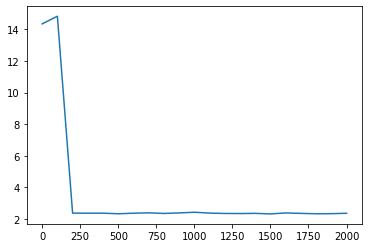

In [ ]:
plt.plot(x_log, loss_log)
plt.show()

In [ ]:
print(t_train.shape)
batch_size = 200
total_correct = 0

running_loss = 0.0
accuracy = 0.0
test_size = 1000
test_data_idx = np.random.choice(x_test.shape[0], test_size)
for i in tqdm(test_data_idx):
    x = x_test[i].reshape(1, 1, 28, 28)
    labels = t_test[i]

    outputs = model.forward(x)
    labels = labels.reshape(outputs.shape)
    c = (np.argmax(labels, 1) == np.argmax(outputs, 1)).squeeze()
    total_correct += np.sum(c)

print(f"Accuracy:{total_correct/test_size}")


(60000, 10)


100%|██████████| 1000/1000 [00:12<00:00, 79.25it/s]

Accuracy:0.098
